# Workgroup 4 

- Andrea Ulloa
- Angela Coapaza
- Ana Angulo

## 1. Causal Forest (R and Python script)

In this lab, we are going to replicate the results obtained in the paper of Athey and Wager (2018) in phyton. First, we download all the packages that we are going to use.

In [7]:
pip install syncrng


Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import pandas as pd
import numpy as np
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from SyncRNG import SyncRNG
import numpy as np
import re
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import linalg
from itertools import chain

from SyncRNG import SyncRNG

from CTL.causal_tree_learn import CausalTree
from sklearn.model_selection import train_test_split
import plotnine as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
random.seed(1)

In [5]:
## Next, we load the data
dataall = pd.read_csv("../../../../data_lab/synthetic_data.csv")
dataall.shape[1]

13

In [6]:
dataall.head(5)

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [7]:
dataall.schoolid = np.multiply(dataall.schoolid,1)

In [8]:
school_id = pd.to_numeric(dataall.schoolid, errors='coerce').astype(int)

In [9]:
school_id

0        76
1        76
2        76
3        76
4        76
         ..
10386     1
10387     1
10388     1
10389     1
10390     1
Name: schoolid, Length: 10391, dtype: int32

In [10]:
school_size = school_id.sum(axis = 0, skipna = True)

In [11]:
school_size

414485

In [12]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.


In [13]:
W = dataall.Z.reset_index( drop = True )
Y = dataall.Y.reset_index( drop = True )
X_raw = dataall.iloc[:, 3:].reset_index( drop = True )

In [14]:
#W = pd.DataFrame(W)
Y = pd.DataFrame(Y)

In [15]:
Y

,Y
0,0.081602
1,-0.385869
2,0.398184
3,-0.175037
4,0.884583
...,...
10386,0.423366
10387,-0.197092
10388,0.141698
10389,-0.351565


In [16]:
X_raw

,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...
10386,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [123]:
X_raw.columns

Index(['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5'], dtype='object')

In [124]:
C1_exp = pd.get_dummies(X_raw["C1"],prefix = "C1")
XC_exp = pd.get_dummies(X_raw["XC"],prefix = "XC")

In [125]:
C1_exp

,C1_1,C1_2,C1_3,C1_4,C1_5,C1_6,C1_7,C1_8,C1_9,C1_10,C1_11,C1_12,C1_13,C1_14,C1_15
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10387,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10389,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [126]:
X = pd.concat([X_raw,C1_exp,XC_exp],axis = 1)
X = X.drop(labels= ["C1","XC"], axis = 1)

In [128]:
X

,S3,C2,C3,X1,X2,X3,X4,X5,C1_1,C1_2,...,C1_11,C1_12,C1_13,C1_14,C1_15,XC_0,XC_1,XC_2,XC_3,XC_4
0,6,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,1,0,0,0,0,0,0,0,1
2,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,1,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10387,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10388,2,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,1,0,0,0,1,0
10389,5,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0


In [135]:
X.columns

Index(['S3', 'C2', 'C3', 'X1', 'X2', 'X3', 'X4', 'X5', 'C1_1', 'C1_2', 'C1_3',
       'C1_4', 'C1_5', 'C1_6', 'C1_7', 'C1_8', 'C1_9', 'C1_10', 'C1_11',
       'C1_12', 'C1_13', 'C1_14', 'C1_15', 'XC_0', 'XC_1', 'XC_2', 'XC_3',
       'XC_4'],
      dtype='object')

## How the tree was built?

In [21]:
#First, we are going to fit two separate regression forest (Y_forest and W_forest)

In [22]:
# Grow a forest. Add extra trees for the causal forest.
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [136]:

Y_forest = RandomForestRegressor(n_estimators=500,oob_score=True )
Y_forest.fit(X, Y.values.ravel())

Y_hat = Y_forest.predict



In [137]:

W_forest = RandomForestRegressor(n_estimators=500,oob_score=True)
W_forest.fit(X, W.values.ravel())

W_hat = W_forest.predict

In [138]:
import econml
from econml.dml import CausalForestDML

from sklearn.ensemble import RandomForestRegressor
from econml.ortho_forest import ContinuousTreatmentOrthoForest as CausalForest
from econml.grf import RegressionForest

In [139]:
# Preparing data to fit a causal forest

fmla = '0+S3+C2+C3+X1+X2+X3+X4+X5'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, dataall, return_type = "dataframe")
X = matrix
W_1 = None

# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.tune(Y, W, X=X, W=W_1)
est2.fit(Y, W, X=X, W=W_1)


In [150]:
# Get residuals  and propensity 
residuals = est2.fit(Y, W, X=X, W=W_1, cache_values=True).residuals_
W_res = residuals[1]
e_hat = W - W_res 



In [151]:
e_hat

0        0.299901
1        0.279902
2        0.298418
3        0.298418
4        0.344523
           ...   
10386    0.325213
10387    0.325213
10388    0.298664
10389    0.314257
10390    0.268340
Name: Z, Length: 10391, dtype: float64

In [152]:
W_res

array([ 0.70009854,  0.7200984 ,  0.7015824 , ..., -0.29866364,
       -0.31425671, -0.26834041])

In [153]:
Prop = pd.DataFrame({"p_score":e_hat, "Treatment":W})

<AxesSubplot:xlabel='p_score', ylabel='Count'>

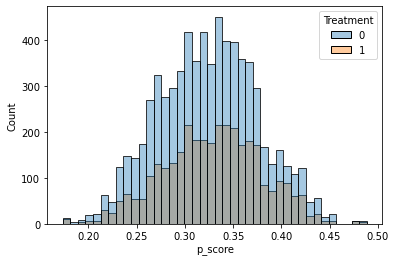

In [154]:
#Propensity score 

sns.histplot(data=Prop, x="p_score", hue="Treatment", bins=40, alpha = 0.4)

In [155]:
tau_hat = est2.effect(X=X) # tau(X) estimates

In [156]:
tau_hat

array([[0.24367215],
       [0.24721428],
       [0.24005003],
       ...,
       [0.20835117],
       [0.20614538],
       [0.20301956]])

Text(0.5, 1.0, 'CATE estimates')

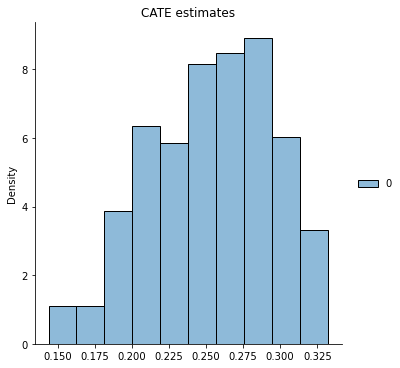

In [157]:
# Do not use this for assessing heterogeneity. See text above.
sns.displot( tau_hat, stat="density", bins = 10)
plt.title("CATE estimates")

In [158]:
est2.feature_importances()

array([[0.03171319, 0.05755682, 0.04663892, 0.26091949, 0.17844769,
        0.08618325, 0.1090396 , 0.22950103]])

In [159]:
importance = pd.DataFrame({"covariaties" : list(X.columns), "values" : est2.feature_importances()})

ValueError: Per-column arrays must each be 1-dimensional

In [160]:
importance.sort_values('values', ascending = False)

NameError: name 'importance' is not defined